In [27]:
%matplotlib inline
import numpy as np
import pandas as pd
import folium
import matplotlib as mpl

from matplotlib import pyplot as plt
from scipy.spatial import distance_matrix

from scipy.spatial import ConvexHull
from shapely.geometry import Polygon, Point, MultiPoint
from numpy import random
from sklearn.neighbors import KDTree
import multiprocessing as mp
import geopandas as gpd

%matplotlib inline
%config InlineBackend.figure_formats = ['png']

In [28]:
%%time
ls_pop = gpd.read_file("./population.shp")
ls_pop.head()

CPU times: user 245 ms, sys: 5.4 ms, total: 250 ms
Wall time: 249 ms


,id,left,top,right,bottom,NUMPOINTS,geometry
0,7.0,-9.789447e+06,5.161431e+06,-9.788947e+06,5.160931e+06,98.0,POINT (-9789192.340 5161030.883)
1,8.0,-9.789447e+06,5.160931e+06,-9.788947e+06,5.160431e+06,5.0,POINT (-9789034.856 5160614.450)
2,8.0,-9.789447e+06,5.160931e+06,-9.788947e+06,5.160431e+06,5.0,POINT (-9789239.640 5160821.023)
3,9.0,-9.789447e+06,5.160431e+06,-9.788947e+06,5.159931e+06,0.0,POINT (-9789119.456 5160154.758)
4,10.0,-9.789447e+06,5.159931e+06,-9.788947e+06,5.159431e+06,0.0,POINT (-9789188.378 5159682.126)


In [29]:
value = ls_pop.iloc[1, 5]
print(value)

5.0


In [30]:
ls_pop['easting'] = ls_pop.geometry.x
ls_pop['northing'] = ls_pop.geometry.y

In [31]:
value_field = 'NUMPOINTS'

In [32]:
total_pop = sum(ls_pop[value_field])
print("The number of records is ", len(ls_pop))
print("The total population are ", total_pop)

The number of records is  4732
The total population are  2856936.0


In [33]:
%%time
site_nodes = gpd.read_file("./sound nodes.shp")
site_nodes.head()

CPU times: user 14.8 ms, sys: 2.79 ms, total: 17.5 ms
Wall time: 15.9 ms


,node_id,project_id,vsn,address,lat,lon,descriptio,start_time,end_timest,geometry
0,001e0610ba46,AoT_Chicago,004,State St & Jackson Blvd Chicago IL,41.878377,-87.627678,AoT Chicago (S) [C],2017/10/09 00:00:00.000,None,POINT (-9754668.494 5142778.283)
1,001e0610ba13,AoT_Chicago,01C,7801 S Lawndale Ave Chicago IL,41.751238,-87.712990,AoT Chicago (S) [C] {ComEd},2018/01/01 00:00:00.000,None,POINT (-9764165.383 5123788.634)
2,001e0610bc10,AoT_Chicago,01F,State St & 87th Chicago IL,41.736314,-87.624179,AoT Chicago (S) [C],2018/02/22 00:00:00.000,None,POINT (-9754278.987 5121562.034)
3,001e0610ba15,AoT_Chicago,02A,Jeffrey Ave & 95th St Chicago IL,41.722457,-87.575350,AoT Chicago (S) [C],2018/02/22 00:00:00.000,None,POINT (-9748843.368 5119495.090)
4,001e0610bbe5,AoT_Chicago,02C,Martin Luther King Dr & 87th St Chicago IL,41.736495,-87.614529,AoT Chicago (S) [C],2018/02/16 00:00:00.000,None,POINT (-9753204.754 5121589.036)


In [34]:
site_nodes['POINT_X'] = site_nodes.geometry.x
site_nodes['POINT_Y'] = site_nodes.geometry.y

In [35]:
sites = np.array(site_nodes[['POINT_X', 'POINT_Y']], dtype=np.float64)

print("The number of sound nodes in Chicago is ", sites.shape[0])
site_nodes.head(3)

The number of sound nodes in Chicago is  35


,node_id,project_id,vsn,address,lat,lon,descriptio,start_time,end_timest,geometry,POINT_X,POINT_Y
0,001e0610ba46,AoT_Chicago,004,State St & Jackson Blvd Chicago IL,41.878377,-87.627678,AoT Chicago (S) [C],2017/10/09 00:00:00.000,None,POINT (-9754668.494 5142778.283),-9.754668e+06,5.142778e+06
1,001e0610ba13,AoT_Chicago,01C,7801 S Lawndale Ave Chicago IL,41.751238,-87.712990,AoT Chicago (S) [C] {ComEd},2018/01/01 00:00:00.000,None,POINT (-9764165.383 5123788.634),-9.764165e+06,5.123789e+06
2,001e0610bc10,AoT_Chicago,01F,State St & 87th Chicago IL,41.736314,-87.624179,AoT Chicago (S) [C],2018/02/22 00:00:00.000,None,POINT (-9754278.987 5121562.034),-9.754279e+06,5.121562e+06


In [36]:
radius = 1000
D = distance_matrix(site_nodes[['POINT_X', 'POINT_Y']].values, ls_pop[['easting', 'northing']].values)
mask1 = D <= radius
D[mask1] = 1
D[~mask1] = 0

backup_cover = np.sum(D, axis=0)

cover_once = [1 if x == 1 else 0 for x in backup_cover]
index_once = np.where(np.array(cover_once) == 1)[0]
print("Covered once points: %s" % index_once)

cover_multi = [1 if y >= 2 else 0 for y in backup_cover]
index_multi = np.where(np.array(cover_multi) == 1)[0]
print("Covered twice points: %s" % index_multi)

cover_all = [1 if z >= 1 else 0 for z in backup_cover]
index_all = np.where(np.array(cover_all) == 1)[0]
print("Covered all points: %s" % index_all)


total_once = 0
for index1 in index_once:
#     print(index1)
    value_once = ls_pop.iloc[index1,5]
    total_once += value_once
print("The number of population coverd once is: %s" % total_once)
print("The percent of population coverd once is: %s" % (total_once/total_pop))
count_of_once = len(index_once)
print("The number of point coverd once is: %s" % count_of_once)

total_twice = 0
for index2 in index_multi:
    value_twice = ls_pop.iloc[index2,5]
    total_twice += value_twice
print("The number of population coverd twice is: %s" % total_twice)
print("The percent of population coverd twice is: %s" % (total_twice/total_pop))
count_of_twice = len(index_multi)
print("The number of point coverd twice is: %s" % count_of_twice)

total = 0
for index3 in index_all:
    value = ls_pop.iloc[index3,5]
    total += value
print("The number of population coverd is: %s" % total)
print("The percent of population coverd is: %s" % (total/total_pop))
count_of_all = len(index_all)
print("The number of point coverd is: %s" % count_of_all)

Covered once points: [ 797  798  799  810  811  812  850  851  852  853  863  864  865  866
  901  902  903  914  915  916  917  952  965  966  973  974 1026 1027
 1028 1029 1080 1081 1082 1083 1137 1138 1139 2021 2022 2115 2116 2117
 2119 2120 2210 2211 2212 2213 2214 2215 2216 2309 2310 2311 2312 2313
 2314 2315 2325 2326 2327 2416 2417 2418 2428 2429 2430 2431 2532 2536
 2543 2544 2552 2553 2559 2629 2630 2631 2636 2640 2641 2646 2647 2648
 2649 2655 2656 2657 2658 2662 2663 2664 2682 2683 2684 2685 2690 2691
 2692 2693 2733 2734 2735 2736 2740 2741 2743 2744 2745 2750 2751 2752
 2753 2759 2760 2761 2762 2766 2767 2768 2769 2785 2786 2787 2789 2790
 2794 2795 2796 2797 2835 2836 2837 2838 2842 2843 2845 2846 2853 2854
 2862 2863 2864 2868 2869 2871 2872 2887 2888 2891 2892 2896 2897 2898
 2899 2939 2940 2973 2974 2975 2976 2991 2992 2993 2994 2995 3069 3070
 3071 3072 3149 3150 3151 3163 3244 3245 3246 3247 3319 3320 3337 3338
 3339 3408 3409 3410 3412 3413 3428 3454 3455 3491 3492 

### Visualization of the input data

In [40]:
def render_scale_bar(ax, x, y, segments=2, height=0.01, seg_length=2000, unit='m', linewidth=1.):
    unit_scale_factor = {
        'm': 1,
        'km': 1000,
        'meters': 1,
        'kilometers': 1000,
        'miles': 1609.34,
        'mi': 1609.34,
        'ft': 0.3,
        }
    x_lim = ax.get_xlim()
    y_lim = ax.get_ylim()

    # how much percent does one unit takes on the x axis
    x_per_unit = 1. / (x_lim[1] - x_lim[0])
    y_per_unit = 1. / (y_lim[1] - y_lim[0])
    
    # base for ticks (0, 1)
    x_base = [x + seg_length * unit_scale_factor[unit] * x_per_unit * i for i in range(0, segments + 1)]  
    ax.axhline(y_lim[0] + y / y_per_unit, x_base[0], x_base[-1], c='black')
    y_base = [y, y + height]
    for i in range(segments + 1):
        ax.axvline(x_lim[0] + x_base[i] / x_per_unit, y, y + height, c='black')
        xy = (x_lim[0] + x_base[i] / x_per_unit, y_lim[0] + (y - 0.015) / y_per_unit)  # data_coords
        ax.text(xy[0], xy[1], s='{}'.format(int(seg_length * i)), horizontalalignment='center', verticalalignment='center')
    ax.text(x_lim[0] + (x_base[-1] + 0.02) / x_per_unit, y_lim[0] + (y - 0.015) / y_per_unit, 
            s=unit, horizontalalignment='left',
            verticalalignment='center')

In [41]:
def render_north_arrow(ax, x, y, size, ratio = 1):
    path = [(0, 1), (-ratio, -1), (0, -0.5), (ratio, -1), (0, 1)]
    path = [(i[0] * size + x, i[1] * size + y) for i in path]
    arrow = plt.Polygon(path, color='black', transform=ax.transAxes)
    ax.add_patch(arrow)
    ax.text(x, y-size*2, s = 'N', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

In [42]:
sitedf1 = site_nodes[site_nodes['POINT_X'] < max(ls_pop['easting'])]
sitedf1 = sitedf1[sitedf1['POINT_X'] > min(ls_pop['easting'])]
sitedf1 = sitedf1[sitedf1['POINT_Y'] < max(ls_pop['northing'])]
sitedf1 = sitedf1[sitedf1['POINT_Y'] > min(ls_pop['northing'])]

CPU times: user 9.96 s, sys: 1.1 s, total: 11.1 s
Wall time: 3.73 s


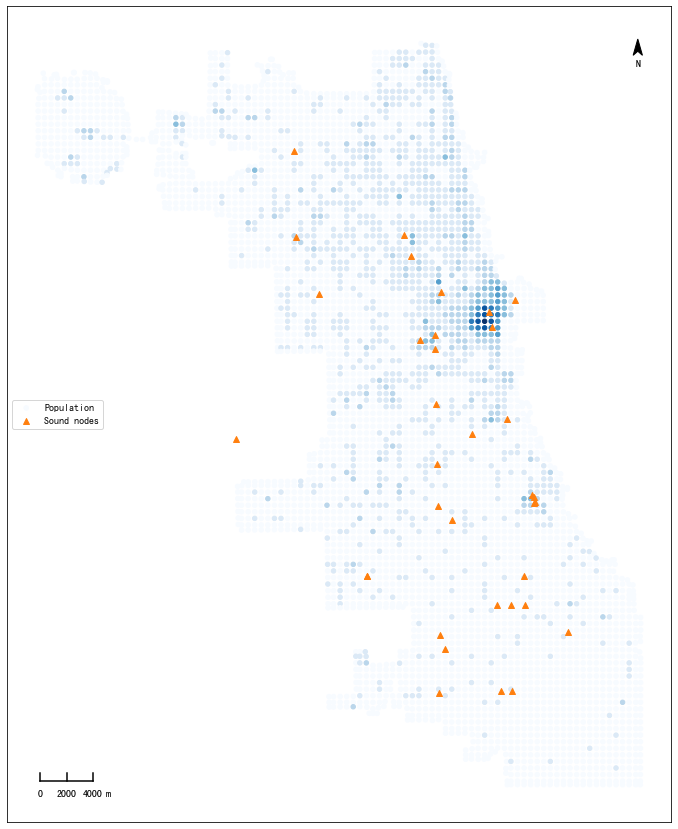

In [43]:
%%time
fig, ax = plt.subplots(figsize=(20,15))

ls_pop.plot(ax = ax, column=ls_pop[value_field], scheme = 'natural_breaks', k=8, markersize=20, cmap='Blues',legend=True, label='Population', legend_kwds={
                                                     'loc': 'center left',
                                                     'title': 'population',
                                                     'shadow': False
                                                 })
ax.scatter(sitedf1['POINT_X'], sitedf1['POINT_Y'], c='C1', s=35, marker='^',label = 'Sound nodes')

ax.axis('scaled')
ax.tick_params(axis='both', left=False, top=False, right=False,
               bottom=False, labelleft=False, labeltop=False,
               labelright=False, labelbottom=False)

render_scale_bar(ax = ax, x=0.05, y=0.05)
render_north_arrow(ax = ax, x = 0.95, y = 0.95, size = 0.01, ratio = 0.7)
ax.legend(loc='center left', markerscale = 1)
fig.savefig('分布图.png', dpi=300)